# Debugging Door Extraction Logic

This notebook breaks down the `solve_door_extraction` function into individual steps using real data from the pipeline.

**Goal:** Extract a door from an image using a bounding box and a mask from `segmentation_results.json`, then warp it to a flat perspective and enhance the details.

In [20]:
import base64
import json
import io
import cv2
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os
import sys
import math

# Ensure we can import from the current directory
sys.path.append(os.getcwd())

# specific import for optional re-run
try:
    from new_segment import extract_segmentation_masks
except ImportError:
    print("Warning: Could not import 'extract_segmentation_masks' from 'new_segment.py'.")

# Helper to display images in Jupyter
def show_img(img, title="Image", cmap=None):
    plt.figure(figsize=(6, 6))
    if len(img.shape) == 3:
        # Convert BGR to RGB for matplotlib
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap=cmap or 'gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

## 1. Setup Data & Image

We load the image `../sample_door_photos/IMG_3104.jpeg` and the JSON output from `segmentation_outputs/segmentation_results.json`.

Loaded image: ../sample_door_photos/IMG_3104.jpeg (3024x4032)


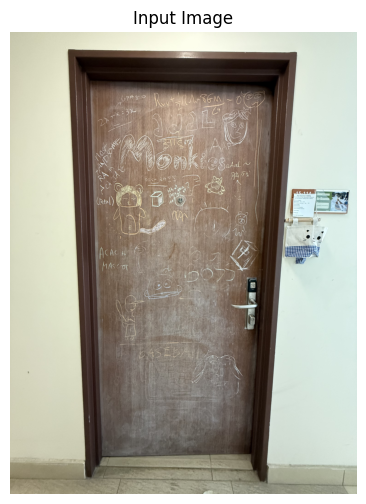

Loaded JSON data with 1 items.


In [21]:
# Configuration
image_path = '../sample_door_photos/IMG_3104.jpeg'
json_path = 'segmentation_outputs/segmentation_results.json'

# Optional: Re-run segmentation if you want to regenerate the JSON
RERUN_SEGMENTATION = False

if RERUN_SEGMENTATION:
    print("Re-running segmentation...")
    extract_segmentation_masks(image_path)
    print("Segmentation complete.")

# Load Image with EXIF Handling
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found at {image_path}")

# Use PIL to load and fix orientation, then convert to OpenCV format
pil_img = Image.open(image_path)
pil_img = ImageOps.exif_transpose(pil_img)
original_img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

img_h, img_w = original_img.shape[:2]
print(f"Loaded image: {image_path} ({img_w}x{img_h})")
show_img(original_img, "Input Image")

# Load JSON
if not os.path.exists(json_path):
    raise FileNotFoundError(f"JSON results not found at {json_path}. Run segmentation first or set RERUN_SEGMENTATION=True.")

with open(json_path, 'r') as f:
    json_data = json.load(f)

print(f"Loaded JSON data with {len(json_data)} items.")

## 2. Parse JSON & Handle Coordinates
We process the first item in the JSON list.

Processing item: the door excluding the doorframe
Bounding Box: (695, 435) to (2283, 3697)
Dimensions: 1588x3262


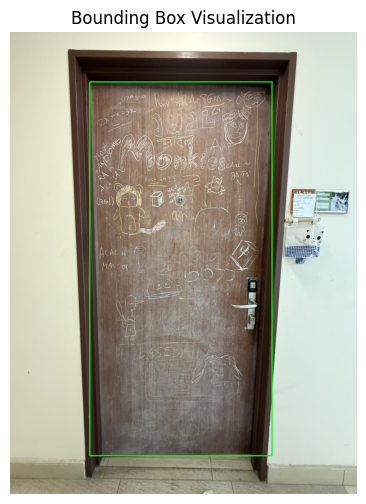

In [22]:
# Parse JSON
item = json_data[0]
box = item['box_2d'] 
label = item.get('label', 'unknown')
print(f"Processing item: {label}")

# Gemini API Standard: [ymin, xmin, ymax, xmax] (Normalized 0-1000)
ymin_norm, xmin_norm, ymax_norm, xmax_norm = box

# Denormalize to Absolute Pixels
y1 = int((ymin_norm / 1000) * img_h)
x1 = int((xmin_norm / 1000) * img_w)
y2 = int((ymax_norm / 1000) * img_h)
x2 = int((xmax_norm / 1000) * img_w)

# Safety clamp
x1, y1 = max(0, x1), max(0, y1)
x2, y2 = min(img_w, x2), min(img_h, y2)

box_w = x2 - x1
box_h = y2 - y1

print(f"Bounding Box: ({x1}, {y1}) to ({x2}, {y2})")
print(f"Dimensions: {box_w}x{box_h}")

if box_w <= 0 or box_h <= 0:
    raise ValueError("Invalid bounding box dimensions detected.")

# Visualize Bounding Box
debug_img = original_img.copy()
cv2.rectangle(debug_img, (x1, y1), (x2, y2), (0, 255, 0), 10)
show_img(debug_img, "Bounding Box Visualization")

## 3. Process Mask

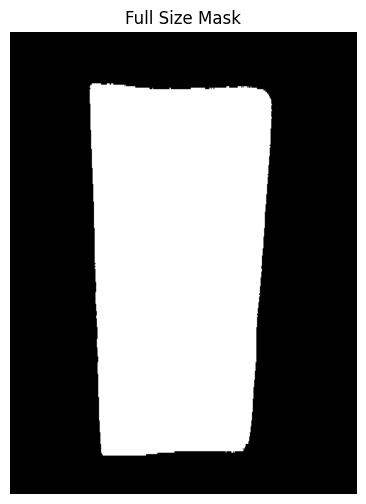

In [23]:
if 'mask' not in item:
    raise ValueError("No 'mask' field found in the item.")

mask_data = item['mask']
if mask_data.startswith('data:'):
    mask_data = mask_data.split(',', 1)[1]

mask_bytes = base64.b64decode(mask_data)
mask_pil = Image.open(io.BytesIO(mask_bytes))

# Resize mask to fit the absolute bounding box
mask_pil = mask_pil.resize((box_w, box_h), resample=Image.NEAREST)
mask_crop = np.array(mask_pil)

# Create Full-Size Mask
full_mask = np.zeros((img_h, img_w), dtype=np.uint8)
full_mask[y1:y2, x1:x2] = mask_crop

show_img(full_mask, "Full Size Mask", cmap='gray')

## 4. Corner Detection (Original Method)

Detected Corners: [[ 714  448]
 [ 794 3671]
 [2034 3658]
 [2276  588]]


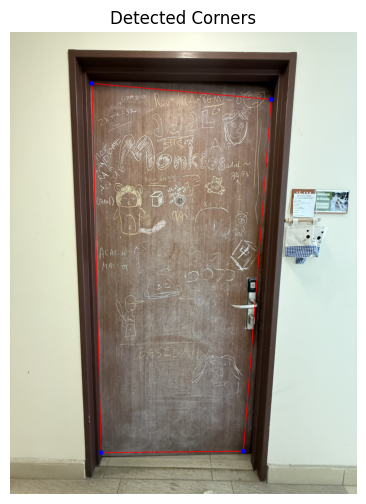

In [24]:
# Find contours in the full mask
contours, _ = cv2.findContours(full_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if not contours:
    raise ValueError("No contours found in mask.")

# Get largest contour (the door)
cnt = max(contours, key=cv2.contourArea)

# Approximate the contour to a polygon (Rectangle = 4 points)
epsilon = 0.02 * cv2.arcLength(cnt, True)
approx = cv2.approxPolyDP(cnt, epsilon, True)

# If approximation failed to get 4 points, use the bounding rect or convex hull
if len(approx) != 4:
    print(f"Info: approxPolyDP returned {len(approx)} points. Falling back to minAreaRect.")
    # Fallback: Just use the bounding box corners if shape is too irregular
    rect = cv2.minAreaRect(cnt)
    box_pts = cv2.boxPoints(rect)
    approx = np.int0(box_pts)

# Reshape to (4, 2)
pts = approx.reshape(4, 2)

print("Detected Corners:", pts)

# Visualize Corners
vis_corners = original_img.copy()
cv2.drawContours(vis_corners, [approx], -1, (0, 0, 255), 5)
for p in pts:
    cv2.circle(vis_corners, tuple(p), 20, (255, 0, 0), -1)
show_img(vis_corners, "Detected Corners")

## 4b. Alternative: Hough Lines Method

This method finds strong straight lines (edges) in the image within the mask area and calculates their intersections to find corners. This is often more robust for geometric shapes like doors where the mask might be 'blobby'.

Found 1546 vertical and 96 horizontal lines.


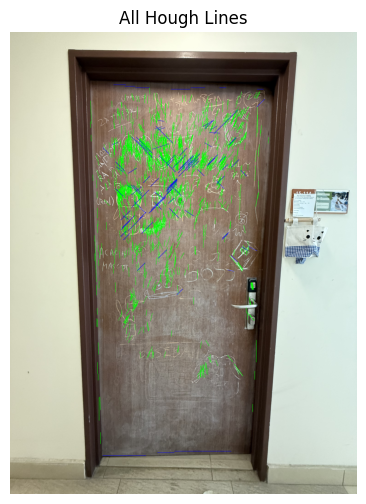

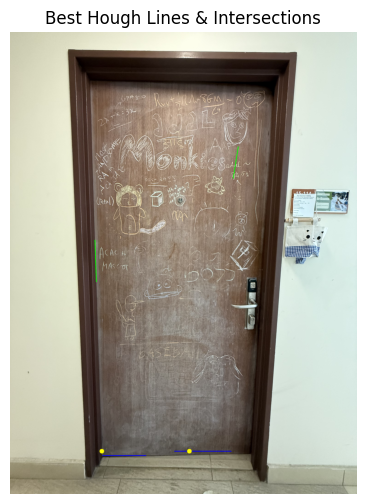

In [25]:
# 1. Edge Detection on Masked Image
# We strictly use the mask to focus on the door area
masked_img = cv2.bitwise_and(original_img, original_img, mask=full_mask)
gray_masked = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray_masked, 50, 150)

# 2. Find Probabilistic Hough Lines
# minLineLength: lines shorter than this are rejected
# maxLineGap: maximum allowed gap between line segments to treat them as single line
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)

if lines is None:
    print("No lines detected!")
else:
    # Separate into Vertical and Horizontal lines
    verticals = []
    horizontals = []
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = abs(np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi)
        
        if 45 < angle < 135:
            verticals.append(line[0])
        else:
            horizontals.append(line[0])

    print(f"Found {len(verticals)} vertical and {len(horizontals)} horizontal lines.")

    # Visualize all lines
    vis_lines = original_img.copy()
    for x1, y1, x2, y2 in verticals:
        cv2.line(vis_lines, (x1, y1), (x2, y2), (0, 255, 0), 2) # Green Verticals
    for x1, y1, x2, y2 in horizontals:
        cv2.line(vis_lines, (x1, y1), (x2, y2), (255, 0, 0), 2) # Blue Horizontals
    
    show_img(vis_lines, "All Hough Lines")

    # Helper to find intersection of two lines given by (x1, y1, x2, y2)
    def get_intersection(line1, line2):
        x1, y1, x2, y2 = line1
        x3, y3, x4, y4 = line2
        
        denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
        if denom == 0:
            return None # Parallel
        
        px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
        py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom
        return (int(px), int(py))

    # Filter: Keep only the longest/strongest lines
    # Simple heuristic: sort by length
    def line_len(l):
        return np.sqrt((l[2]-l[0])**2 + (l[3]-l[1])**2)
    
    verticals.sort(key=line_len, reverse=True)
    horizontals.sort(key=line_len, reverse=True)
    
    # We assume 2 main verticals (left/right) and at least 1 main horizontal (top)
    # The bottom might be ill-defined (floor), so we might need to rely on the mask bottom or find the bottom edge
    
    best_verts = verticals[:2]
    best_horiz = horizontals[:2] # Try to get top and bottom

    vis_best = original_img.copy()
    
    # Sort verticals by X to find Left and Right
    best_verts.sort(key=lambda l: (l[0] + l[2])/2)
    if len(best_verts) >= 2:
        left_wall = best_verts[0]
        right_wall = best_verts[-1]
    else:
        left_wall = right_wall = None
        
    # Sort horizontals by Y to find Top and Bottom
    best_horiz.sort(key=lambda l: (l[1] + l[3])/2)
    if len(best_horiz) >= 2:
        top_frame = best_horiz[0]
        bot_frame = best_horiz[-1]
    elif len(best_horiz) == 1:
        top_frame = best_horiz[0]
        bot_frame = None
    else:
        top_frame = bot_frame = None

    hough_pts = []
    
    if left_wall is not None and top_frame is not None:
        p = get_intersection(left_wall, top_frame)
        if p: hough_pts.append(p)
    if right_wall is not None and top_frame is not None:
        p = get_intersection(right_wall, top_frame)
        if p: hough_pts.append(p)
        
    # Draw best lines
    for l in best_verts: cv2.line(vis_best, (l[0], l[1]), (l[2], l[3]), (0, 255, 0), 5)
    for l in best_horiz: cv2.line(vis_best, (l[0], l[1]), (l[2], l[3]), (255, 0, 0), 5)
    
    # Draw intersections
    for p in hough_pts:
        cv2.circle(vis_best, p, 20, (0, 255, 255), -1)
        
    show_img(vis_best, "Best Hough Lines & Intersections")

    # Replace 'pts' with hough_pts if we found 4 reliable ones, 
    # OR mix and match (keep mask corners if hough fails)
    # For this demo, let's just observe the result.


## 5. Order Points & Perspective Warp

In [ ]:
# Filter pts to use. Let's use the original 'pts' from approxPolyDP for now,
# or substitute if you are happy with the Hough result above.
# pts = np.array(hough_pts) # Uncomment this if hough_pts gave >3 good points

# Ensure we have 4 points for the transform
if len(pts) != 4:
    # Fallback if detection failed
    print("Warning: Do not have 4 points. Using original mask rect.")
    # Re-calculate box points from minAreaRect of mask
    rect = cv2.minAreaRect(cnt)
    pts = np.int0(cv2.boxPoints(rect))

# Sort by Y (Top vs Bottom)
pts = pts[np.argsort(pts[:, 1])]

# Top two points (Top-Left, Top-Right)
top_pts = pts[:2]
top_pts = top_pts[np.argsort(top_pts[:, 0])] # Sort by X
tl, tr = top_pts

# Bottom two points
bot_pts = pts[2:]
bot_pts = bot_pts[np.argsort(bot_pts[:, 0])]
bl, br = bot_pts

src_pts = np.array([tl, tr, br, bl], dtype="float32")

print("Ordered Source Points:")
print(f"TL: {tl}, TR: {tr}")
print(f"BL: {bl}, BR: {br}")

# Perspective Warp
out_w, out_h = 1000, 2500 # High-res door ratio
dst_pts = np.array([[0, 0], [out_w, 0], [out_w, out_h], [0, out_h]], dtype="float32")

M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warped_img = cv2.warpPerspective(original_img, M, (out_w, out_h))

show_img(warped_img, "Warped Image")

## 6. Chalk/Detail Enhancement

In [ ]:
# Convert to LAB for luminance control
lab = cv2.cvtColor(warped_img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)

# CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl = clahe.apply(l)

enhanced_lab = cv2.merge((cl, a, b))
enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

# Optional: Sharpening kernel
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharpened = cv2.filter2D(enhanced, -1, kernel)

show_img(sharpened, "Enhanced & Sharpened Result")

## Save Results

In [ ]:
cv2.imwrite('result_cleaned.jpg', warped_img)
cv2.imwrite('result_chalk.jpg', sharpened)
print("Saved 'result_cleaned.jpg' and 'result_chalk.jpg'")